In [2]:
import os
import json
import cv2

base_path = '/home/jaehoonahn/LATR/data/openlane'
image_path = 'images/validation/segment-17065833287841703_2980_000_3000_000_with_camera_labels/155362886424889300.jpg'
gt_path = 'lane3d_1000/validation/segment-17065833287841703_2980_000_3000_000_with_camera_labels/155362886424889300.json'

image_file = os.path.join(base_path,image_path)
gt_file = os.path.join(base_path,gt_path)

image = cv2.imread(image_file)

with open(gt_file, 'r', encoding='utf-8') as f:
    gt = json.load(f)


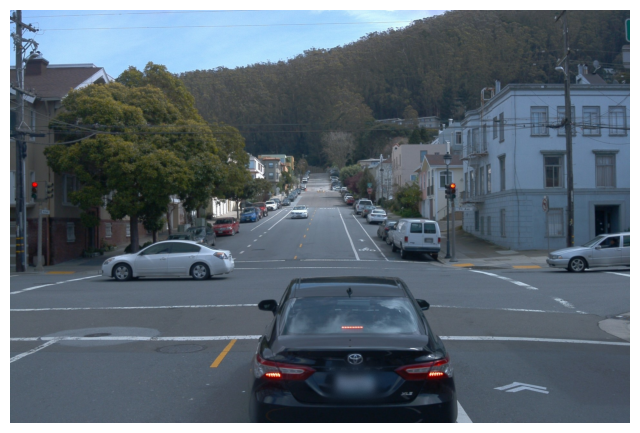

In [3]:
import matplotlib.pyplot as plt

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [11]:
import numpy as np

values = list(gt.values())
extrinsic = np.array(values[0])
intrinsic = np.array(values[1])

lanes = values[2]

lane_uv = []
lane_xyz = []
lane_type = []

for i in range(len(lanes)):
    uv = np.array(lanes[i]['uv']).T
    xyz = np.array(lanes[i]['xyz']).T
    category = np.array(lanes[i]['category']).T
    
    lane_uv.append(uv)
    lane_xyz.append(xyz)
    lane_type.append(category)

lane_uv = np.array(lane_uv)
lane_xyz = np.array(lane_xyz)

/tmp/ipykernel_3294951/429778857.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lane_uv = np.array(lane_uv)
/tmp/ipykernel_3294951/429778857.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lane_xyz = np.array(lane_xyz)


In [43]:
# 카테고리별 색상 (BGR 순서)
CATEGORY_COLORS = {
    0: (128, 128, 128),     # unknown - gray
    1: (255, 255, 255),     # white-dash - white
    2: (200, 200, 200),     # white-solid - light gray
    3: (255, 255, 180),     # double-white-dash - off white
    4: (200, 200, 180),     # double-white-solid - grayish white
    5: (220, 255, 200),     # white-ldash-rsolid - pale green
    6: (200, 255, 220),     # white-lsolid-rdash - pale cyan
    7: (0, 255, 255),       # yellow-dash - yellow
    8: (0, 200, 200),       # yellow-solid - dark yellow
    9: (0, 180, 255),       # double-yellow-dash - orange
    10: (0, 140, 255),      # double-yellow-solid - dark orange
    11: (0, 160, 200),      # yellow-ldash-rsolid - cyan yellow
    12: (0, 200, 160),      # yellow-lsolid-rdash - teal yellow
    20: (255, 0, 0),        # left-curbside - blue
    21: (0, 0, 255),        # right-curbside - red
}

# 카테고리별 이름
CATEGORY_NAMES = {
    0: 'unknown',
    1: 'white-dash',
    2: 'white-solid',
    3: 'double-white-dash',
    4: 'double-white-solid',
    5: 'white-ldash-rsolid',
    6: 'white-lsolid-rdash',
    7: 'yellow-dash',
    8: 'yellow-solid',
    9: 'double-yellow-dash',
    10: 'double-yellow-solid',
    11: 'yellow-ldash-rsolid',
    12: 'yellow-lsolid-rdash',
    20: 'left-curbside',
    21: 'right-curbside',
}

def visualize_lanes_on_image(image, projected_lanes, categories):
    legend_entries = set()
    for lane, cat in zip(projected_lanes, categories):
        cat = int(cat)
        color = CATEGORY_COLORS.get(cat, (128, 128, 128))
        legend_entries.add(cat)
        for i in range(len(lane) - 1):
            pt1 = tuple(np.round(lane[i]).astype(int))
            pt2 = tuple(np.round(lane[i+1]).astype(int))
            cv2.line(image, pt1, pt2, color, 5)

    # 범례 그리기 (왼쪽 위에)
    x0, y0 = 10, 10
    for idx, cat in enumerate(sorted(legend_entries)):
        color = CATEGORY_COLORS[cat]
        name = CATEGORY_NAMES.get(cat, 'unknown')
        y = y0 + idx * 60
        cv2.rectangle(image, (x0, y), (x0+40, y+40), color, -1)
        cv2.putText(image, name, (x0 + 45, y + 35), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

    return image

In [44]:
def project_xyz_to_image(xyz_list, extrinsic, intrinsic):
    uv_all = []

    cam_representation = np.linalg.inv(
        np.array([[0, 0, 1, 0],
                [-1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, 0, 1]], dtype=float)) # waymo camera to normal camera

    for xyz in xyz_list:
        if xyz.shape[0] == 0:
            uv_all.append(np.empty((0, 2)))
            continue

        num_points = xyz.shape[0]
        xyz_hom = np.hstack([xyz, np.ones((num_points, 1))])  # shape: (N, 4)
        # 1. shape: (N, 3)
        cam_xyz_hom = (cam_representation @ xyz_hom.T).T # waymo camera to normal camera
        cam_xyz = cam_xyz_hom[:, :3]

        # 2. 투영
        uv_hom = (intrinsic @ cam_xyz.T).T  # shape: (N, 3)
        uv = uv_hom[:, :2] / uv_hom[:, 2:3]  # normalize

        uv_all.append(uv)

    return uv_all

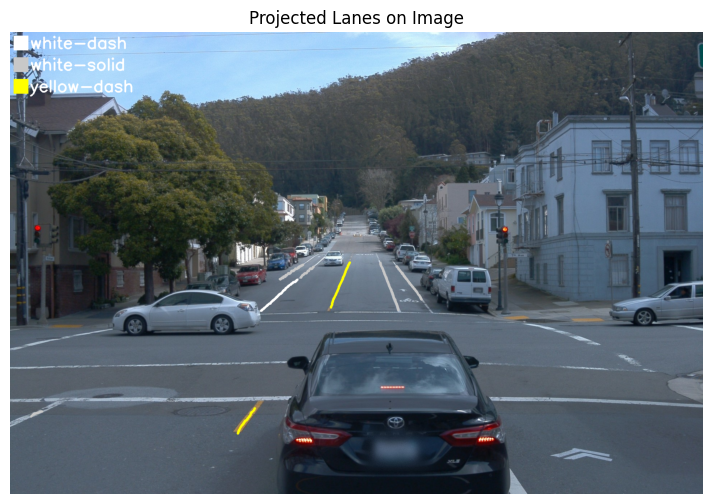

In [45]:
lane = project_xyz_to_image(lane_xyz, extrinsic, intrinsic)
image_with_projected_lanes = visualize_lanes_on_image(image.copy(), lane, lane_type)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image_with_projected_lanes, cv2.COLOR_BGR2RGB))
plt.title("Projected Lanes on Image")
plt.axis("off")
plt.show()

In [63]:
CATEGORY_COLORS_3D = {
    0: (0.5, 0.5, 0.5),      # gray
    1: (1.0, 1.0, 1.0),      # white
    2: (0.8, 0.8, 0.8),      # light gray
    3: (1.0, 1.0, 0.7),      # off white
    4: (0.7, 0.7, 0.6),      # dirty white
    5: (0.9, 1.0, 0.8),      # pale green
    6: (0.8, 1.0, 0.9),      # pale cyan
    7: (1.0, 1.0, 0.0),      # yellow
    8: (0.8, 0.8, 0.0),      # dark yellow
    9: (1.0, 0.7, 0.0),      # orange
    10: (1.0, 0.5, 0.0),     # dark orange
    11: (0.8, 0.9, 0.3),     # lime yellow
    12: (0.5, 1.0, 0.6),     # green yellow
    20: (0.0, 0.0, 1.0),     # blue
    21: (1.0, 0.0, 0.0),     # red
}

def plot_lanes_3d(lane_list, category_list):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    all_points = []
    legend_handles = {}

    for lane, cat in zip(lane_list, category_list):
        lane = np.array(lane)
        if lane.shape[1] != 3:
            raise ValueError("Each lane must be of shape (P, 3)")

        x, y, z = lane[:, 0], lane[:, 1], lane[:, 2]
        color = CATEGORY_COLORS_3D.get(int(cat), (0.5, 0.5, 0.5))
        label = CATEGORY_NAMES.get(int(cat), 'unknown')

        # 범례 중복 방지
        if label not in legend_handles:
            handle, = ax.plot(x, y, z, linewidth=2, color=color, label=label)
            legend_handles[label] = handle
        else:
            ax.plot(x, y, z, linewidth=2, color=color)

        all_points.append(lane)

    # 동일 스케일 설정
    all_points = np.concatenate(all_points, axis=0)
    x_vals, y_vals, z_vals = all_points[:, 0], all_points[:, 1], all_points[:, 2]
    max_range = np.array([x_vals.max() - x_vals.min(),
                          y_vals.max() - y_vals.min(),
                          z_vals.max() - z_vals.min()]).max() / 2.0

    mid_x = (x_vals.max() + x_vals.min()) / 2
    mid_y = (y_vals.max() + y_vals.min()) / 2
    mid_z = (z_vals.max() + z_vals.min()) / 2

    ax.scatter(0, 0, 0, color='red', s=100, label='Ego')

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X (Forward)')
    ax.set_ylabel('Y (Right)')
    ax.set_zlabel('Z (Up)')
    ax.set_title('3D Lane Visualization')
    ax.view_init(elev=40, azim=150)

    # 범례 추가
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()


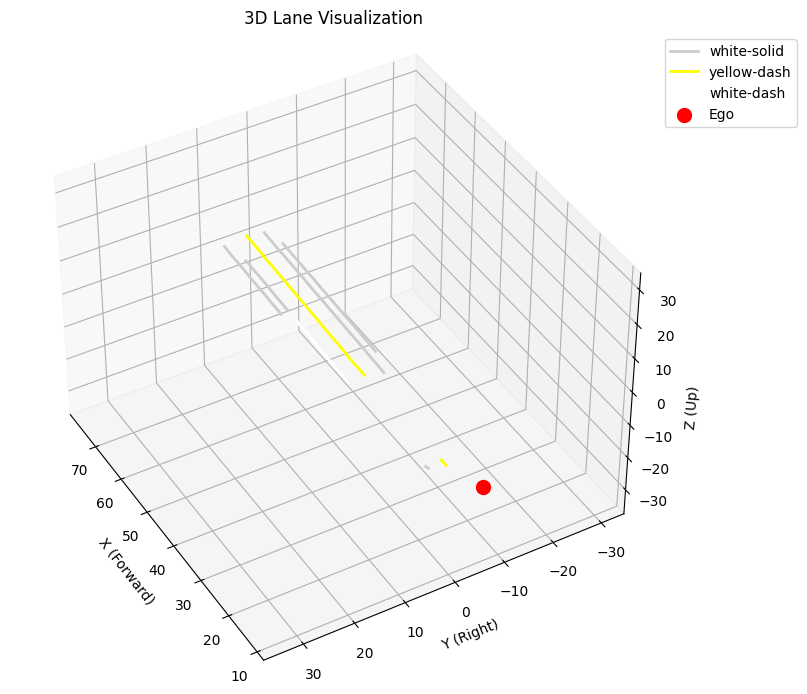

In [65]:
plot_lanes_3d(lane_xyz, lane_type)